<a href="https://colab.research.google.com/github/Atk2045/data_bootcamp_final/blob/main/Model1_EDA_and_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
data_2021_2022 = pd.read_csv("/content/2020-2021.csv")
data_2022_2023 = pd.read_csv("/content/2021-2022.csv")
data_2021_2022['Season'] = '2021/22'
data_2022_2023['Season'] = '2022/23'

# Combine datasets together
match_data = pd.concat([data_2021_2022, data_2022_2023], ignore_index=True)
print(match_data.head(15))
print(match_data.columns)

   Div        Date   Time          HomeTeam        AwayTeam  FTHG  FTAG FTR  \
0   E0  12/09/2020  12:30            Fulham         Arsenal     0     3   A   
1   E0  12/09/2020  15:00    Crystal Palace     Southampton     1     0   H   
2   E0  12/09/2020  17:30         Liverpool           Leeds     4     3   H   
3   E0  12/09/2020  20:00          West Ham       Newcastle     0     2   A   
4   E0  13/09/2020  14:00         West Brom       Leicester     0     3   A   
5   E0  13/09/2020  16:30         Tottenham         Everton     0     1   A   
6   E0  14/09/2020  20:15          Brighton         Chelsea     1     3   A   
7   E0  14/09/2020  18:00  Sheffield United          Wolves     0     2   A   
8   E0  19/09/2020  12:30           Everton       West Brom     5     2   H   
9   E0  19/09/2020  15:00             Leeds          Fulham     4     3   H   
10  E0  19/09/2020  17:30        Man United  Crystal Palace     1     3   A   
11  E0  19/09/2020  20:00           Arsenal        W

In [ ]:
summary_stats = match_data.describe()
print(summary_stats)

             FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  760.000000  760.000000  760.000000  760.000000  760.000000  760.000000   
mean     1.432895    1.323684    0.673684    0.597368   13.331579   11.550000   
std      1.325029    1.257585    0.828569    0.807405    5.596964    5.119919   
min      0.000000    0.000000    0.000000    0.000000    1.000000    1.000000   
25%      0.000000    0.000000    0.000000    0.000000    9.000000    8.000000   
50%      1.000000    1.000000    0.000000    0.000000   13.000000   11.000000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   15.000000   
max      9.000000    7.000000    4.000000    4.000000   31.000000   31.000000   

              HST         AST          HF          AF  ...    AvgC<2.5  \
count  760.000000  760.000000  760.000000  760.000000  ...  760.000000   
mean     4.611842    4.113158   10.639474   10.353947  ...    2.066237   
std      2.596362    2.428495    3.488210    3.6

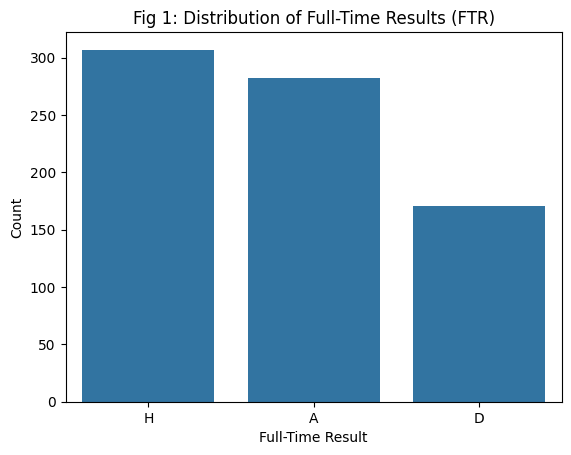

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.countplot(data=match_data, x='FTR', order=match_data['FTR'].value_counts().index)
plt.title("Fig 1: Distribution of Full-Time Results (FTR)")
plt.xlabel("Full-Time Result")
plt.ylabel("Count")
plt.show()
plt.savefig('plot1.png')

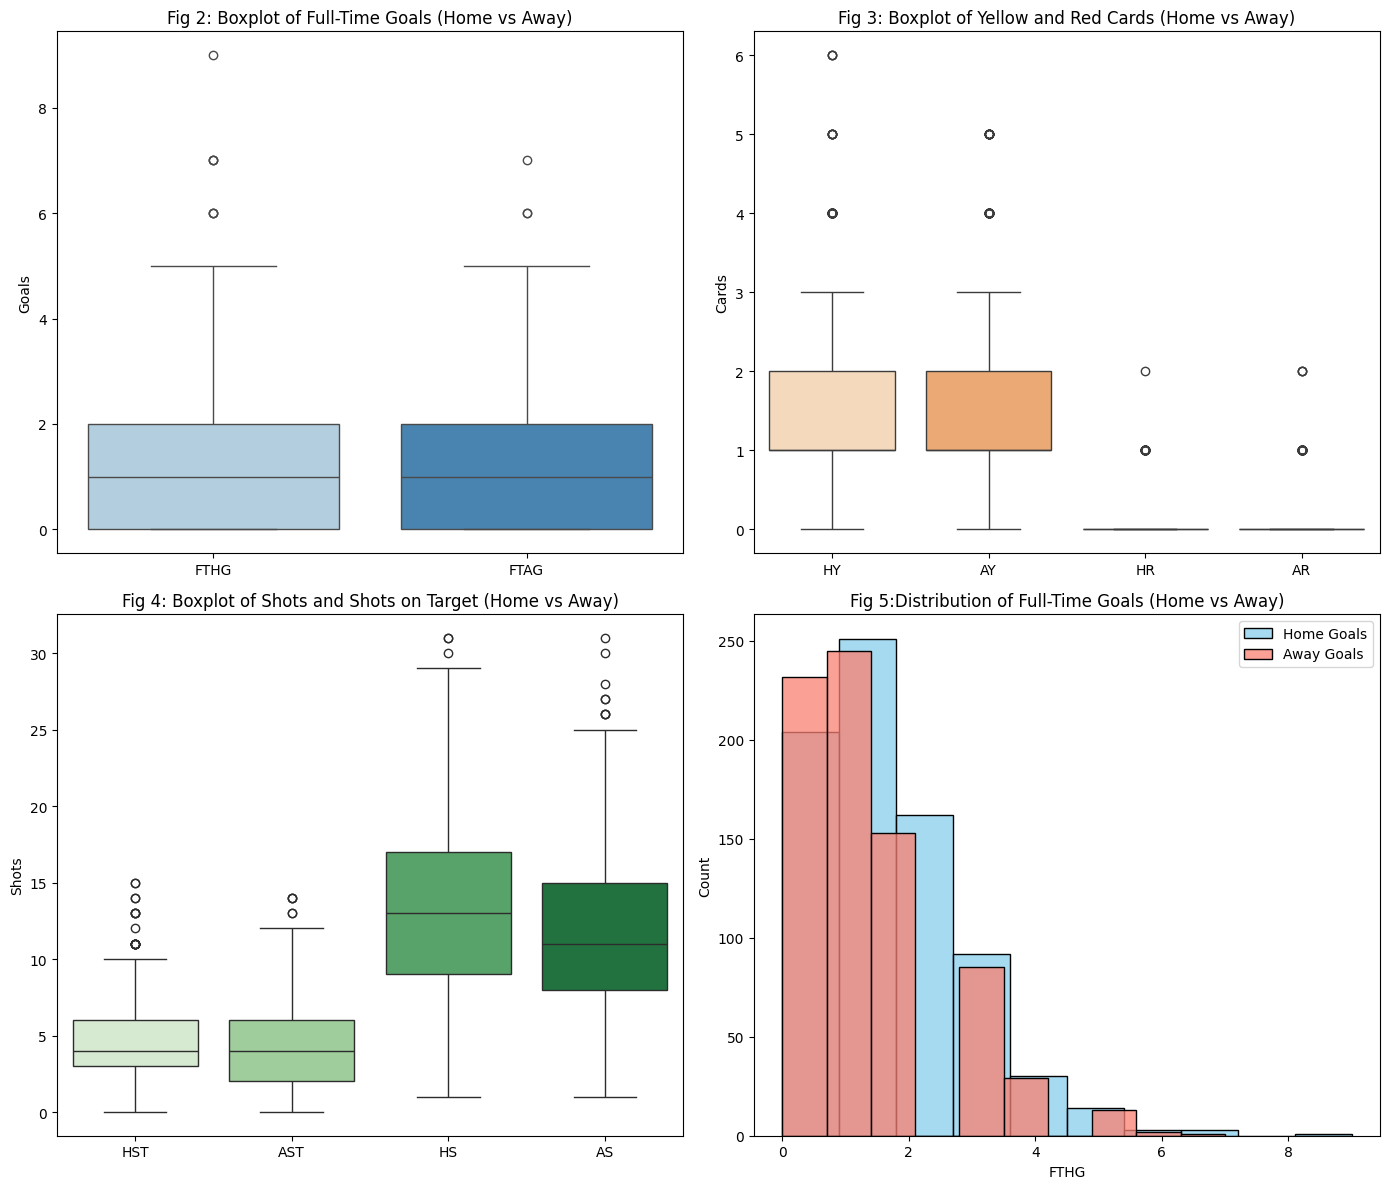

In [ ]:
goal_features = ['FTHG', 'FTAG']
card_features = ['HY', 'AY', 'HR', 'AR']
shot_features = ['HST', 'AST', 'HS', 'AS']

plt.figure(figsize=(14, 12))
plt.subplot(2, 2, 1)
sns.boxplot(data=match_data[goal_features], palette="Blues")
plt.title("Fig 2: Boxplot of Full-Time Goals (Home vs Away)")
plt.ylabel("Goals")

plt.subplot(2, 2, 2)
sns.boxplot(data=match_data[card_features], palette="Oranges")
plt.title("Fig 3: Boxplot of Yellow and Red Cards (Home vs Away)")
plt.ylabel("Cards")

plt.subplot(2, 2, 3)
sns.boxplot(data=match_data[shot_features], palette="Greens")
plt.title("Fig 4: Boxplot of Shots and Shots on Target (Home vs Away)")
plt.ylabel("Shots")

plt.subplot(2, 2, 4)
sns.histplot(data=match_data, x='FTHG', color="skyblue", label="Home Goals", bins=10)
sns.histplot(data=match_data, x='FTAG', color="salmon", label="Away Goals", bins=10)
plt.title("Fig 5:Distribution of Full-Time Goals (Home vs Away)")
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('plot2.png')
plt.close()

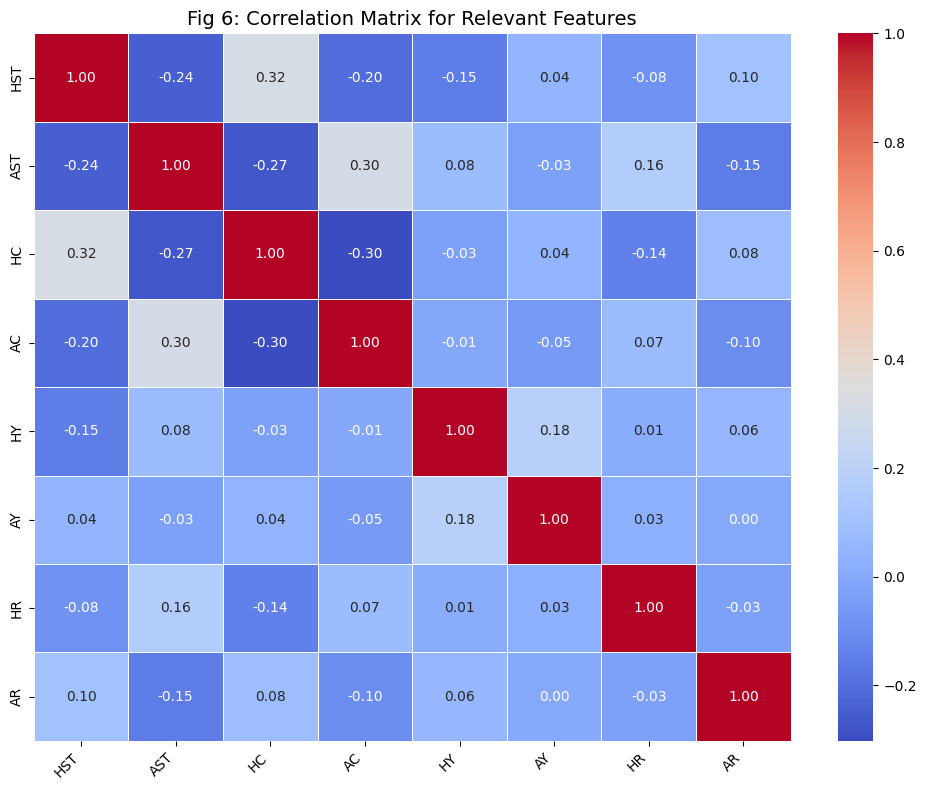

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix and heat map
corr_matrix = match_data[[ 'HST', 'AST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']].corr()
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            linewidths=.5, annot_kws={"size": 10})  # Customize annotations and lines

# Set title and rotate x-axis labels
plt.title("Fig 6: Correlation Matrix for Relevant Features", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Define the target variable
y = match_data['FTR'].map({'H': 0, 'D': 1, 'A': 2})  # Encode match outcomes

# Baseline prediction: predict the majority class
baseline_preds = np.ones(len(y)) * y.mode()[0]
baseline_accuracy = accuracy_score(y, baseline_preds)

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.40


In [ ]:
# Define features and target and train and test
features = ['HST', 'AST', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
X = match_data[features]
y = match_data['FTR'].map({'H': 0, 'D': 1, 'A': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Preprocessing: standardize numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features)
    ]
)


In [ ]:
# Logistic Regression pipeline
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=500, random_state=50))
])

# Train the model and predictions
logistic_pipeline.fit(X_train, y_train)
y_pred = logistic_pipeline.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        64
           1       0.35      0.53      0.42        32
           2       0.80      0.77      0.78        56

    accuracy                           0.64       152
   macro avg       0.63      0.63      0.62       152
weighted avg       0.68      0.64      0.65       152



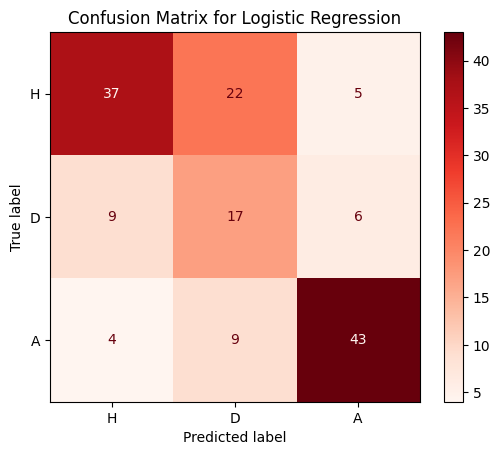

In [ ]:
# the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['H', 'D', 'A'])

# Plot for it
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
# Decision Tree pipeline
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced',random_state=50))
])

# Grid search for hyperparameters
param_grid = {
    'classifier__max_depth': [2, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

tree_search = GridSearchCV(tree_pipeline, param_grid, cv=5, scoring='accuracy')
tree_search.fit(X_train, y_train)

# Best model
best_tree = tree_search.best_estimator_
y_pred_tree = best_tree.predict(X_test)

# Evaluation
print(f"Best Parameters for Decision Tree: {tree_search.best_params_}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))


Best Parameters for Decision Tree: {'classifier__max_depth': 2, 'classifier__min_samples_split': 2}
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.47      0.53        64
           1       0.32      0.25      0.28        32
           2       0.56      0.79      0.66        56

    accuracy                           0.54       152
   macro avg       0.50      0.50      0.49       152
weighted avg       0.53      0.54      0.52       152



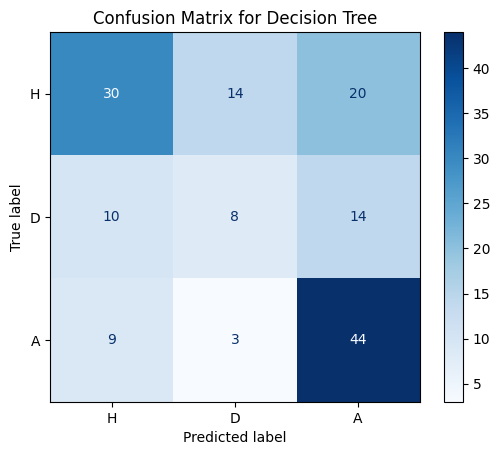

In [ ]:
# Generate the confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree,
                                   display_labels=['H', 'D', 'A'])

# Plotted
disp_tree.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced',random_state=50))
])

# Grid search for hyperparameters
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

rf_search = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy')
rf_search.fit(X_train, y_train)

# Best model
best_rf = rf_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluation
print(f"Best Parameters for Random Forest: {rf_search.best_params_}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Best Parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61        64
           1       0.28      0.22      0.25        32
           2       0.64      0.80      0.71        56

    accuracy                           0.59       152
   macro avg       0.52      0.53      0.52       152
weighted avg       0.57      0.59      0.57       152



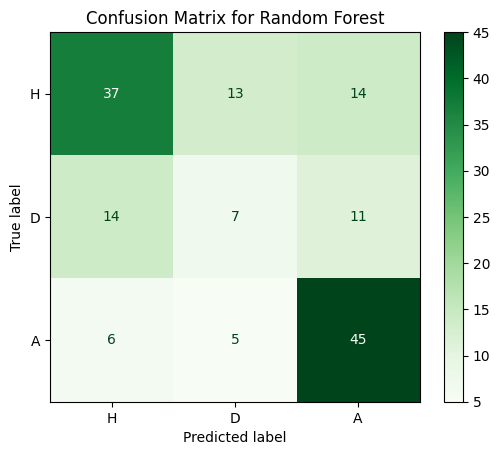

In [ ]:
# Generate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                   display_labels=['H', 'D', 'A'])
# Plotted
disp_rf.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [ ]:
models = {
    "Baseline": {"Accuracy": baseline_accuracy},
    "Logistic Regression": {"Accuracy": logistic_pipeline.score(X_test, y_test)},
    "Decision Tree": {"Accuracy": tree_search.best_score_},
    "Random Forest": {"Accuracy": rf_search.best_score_},
}
df = pd.DataFrame.from_dict(models, orient='index')
df = df.sort_values(by=['Accuracy'])
df = df.applymap(lambda x: f'{x:.2g}' if isinstance(x, (float, int)) else x)

# Add a border and center the text
styled_df = df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
])
display(styled_df)


,Accuracy
Baseline,0.4
Decision Tree,0.54
Random Forest,0.57
Logistic Regression,0.64
